In [120]:
import numpy as np
import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GINConv, global_mean_pool,global_max_pool, BatchNorm, GraphNorm
from sklearn.model_selection import train_test_split

In [121]:
# Constants for your data
NUM_NODES = 33      # Number of pose points
NUM_FEATURES = 3    # x, y, z for each point
NUM_CLASSES = 8     # Your 8 swing event classes
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 0.005

In [122]:
# ----- Build adjacency matrix and edge_index -----
edge_index = torch.tensor([
    [12, 14, 16, 16, 16, 18, 11, 13, 15, 15, 15, 17, 11, 24, 26, 28, 28, 30, 23, 25, 27, 27, 29, 11, 12, 9, 0, 1, 2, 3, 0, 4, 5, 6],
    [14, 16, 18, 20, 22, 20, 13, 15, 17, 19, 21, 19, 12, 26, 28, 30, 32, 32, 25, 27, 29, 31, 31, 23, 24, 10, 1, 2, 3, 7, 4, 5, 6, 8]
], dtype=torch.long)

In [123]:
# Dataset class
class PoseGraphDataset(InMemoryDataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        super().__init__('.')  # Use current directory
        self.data, self.slices = self._process()

    def _process(self):
        data_list = []
        for pose_flat, label in zip(self.X, self.y):
            pose = pose_flat.reshape(NUM_NODES, NUM_FEATURES)
            x = torch.tensor(pose, dtype=torch.float)
            y_t = torch.tensor(label, dtype=torch.long)
            data = Data(x=x, edge_index=edge_index, y=y_t)
            data_list.append(data)
        return self.collate(data_list)

In [124]:
# Load your data
data_np = np.load('../data/segmentedPose_augmented.npy')
X = data_np[:, :-1]
y = data_np[:, -1].astype(int)

In [125]:
# Create dataset
dataset = PoseGraphDataset(X, y)

# Train/test split
indices = np.arange(len(dataset))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=67)

train_dataset = dataset[torch.tensor(train_idx)]
test_dataset = dataset[torch.tensor(test_idx)]

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [126]:
# Define GCN model
class FinalGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GATConv(num_features, 64, heads=4, concat=True)
        self.bn1 = torch.nn.BatchNorm1d(64 * 4)

        self.conv2 = GATConv(64 * 4, 128, heads=4, concat=True)
        self.bn2 = torch.nn.BatchNorm1d(128 * 4)

        self.conv3 = GATConv(128 * 4, 128, heads=6, concat=False)  # concat=False for last layer to reduce dim
        self.bn3 = torch.nn.BatchNorm1d(128)

        self.dropout = torch.nn.Dropout(dropout)

        self.lin1 = torch.nn.Linear(128, 64)
        self.lin2 = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)

        x = global_max_pool(x, data.batch)  # can also try global_mean_pool

        x = self.dropout(x)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.lin2(x)

        return F.log_softmax(x, dim=-1)

In [127]:
class MixedGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden1=64, hidden2=64, hidden3=128, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden1)
        self.bn1 = GraphNorm(hidden1)

        self.conv2 = GATConv(hidden1, hidden2, heads=4, concat=True)  # output: hidden2 * 4 = 256
        self.bn2 = GraphNorm(hidden2 * 4)

        # Linear projection for residual connection
        self.res_proj = torch.nn.Linear(hidden1, hidden2 * 4)

        self.conv3 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(hidden2 * 4, hidden3),
                torch.nn.ELU(),
                torch.nn.Linear(hidden3, hidden3)
            )
        )
        self.bn3 = GraphNorm(hidden3)

        self.lin = torch.nn.Linear(hidden3, num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = F.elu(self.bn1(self.conv1(x, edge_index)))
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        x2 = F.elu(self.bn2(self.conv2(x1, edge_index)))
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        x1_proj = self.res_proj(x1)
        x3_in = x2 + x1_proj  # Now same dims

        x3 = F.elu(self.bn3(self.conv3(x3_in, edge_index)))
        x3 = F.dropout(x3, p=self.dropout, training=self.training)

        x = global_mean_pool(x3, data.batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MixedGCN(NUM_FEATURES, NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.NLLLoss()

In [129]:
# Training loop
def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs  # sum loss weighted by batch size
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.num_graphs

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [130]:
def test(loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs

    accuracy = correct / total
    return accuracy

In [131]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train()
    test_acc = test(test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 001 | Train Loss: 1.7173 | Train Acc: 0.3203 | Test Acc: 0.3381
Epoch 002 | Train Loss: 1.6108 | Train Acc: 0.4014 | Test Acc: 0.3239
Epoch 003 | Train Loss: 1.5163 | Train Acc: 0.4488 | Test Acc: 0.4397
Epoch 004 | Train Loss: 1.4381 | Train Acc: 0.4950 | Test Acc: 0.4208
Epoch 005 | Train Loss: 1.4053 | Train Acc: 0.4808 | Test Acc: 0.4894
Epoch 006 | Train Loss: 1.3466 | Train Acc: 0.5044 | Test Acc: 0.5437
Epoch 007 | Train Loss: 1.2984 | Train Acc: 0.5376 | Test Acc: 0.4846
Epoch 008 | Train Loss: 1.2920 | Train Acc: 0.5228 | Test Acc: 0.5485
Epoch 009 | Train Loss: 1.2448 | Train Acc: 0.5364 | Test Acc: 0.5508
Epoch 010 | Train Loss: 1.2064 | Train Acc: 0.5631 | Test Acc: 0.5343
Epoch 011 | Train Loss: 1.1831 | Train Acc: 0.5702 | Test Acc: 0.5603
Epoch 012 | Train Loss: 1.1494 | Train Acc: 0.5856 | Test Acc: 0.5910
Epoch 013 | Train Loss: 1.1151 | Train Acc: 0.5980 | Test Acc: 0.5887
Epoch 014 | Train Loss: 1.1170 | Train Acc: 0.6057 | Test Acc: 0.5650
Epoch 015 | Train Lo

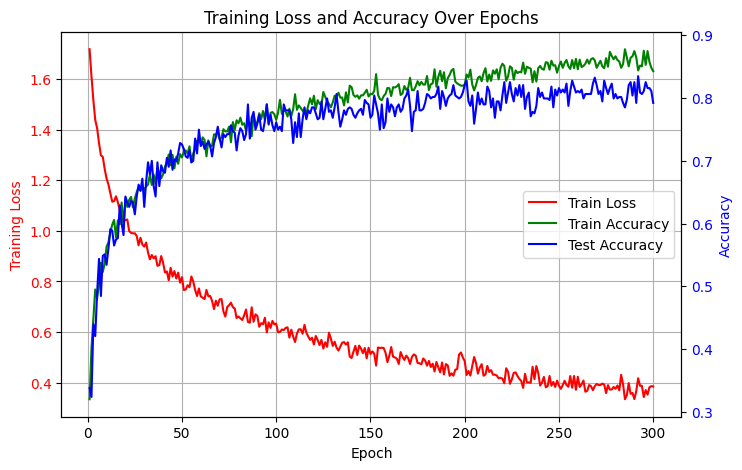

In [132]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot training loss on left y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color='red')
ax1.plot(epochs, train_losses, 'r-', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True)

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='blue')
ax2.plot(epochs, train_accuracies, 'g-', label='Train Accuracy')
ax2.plot(epochs, test_accuracies, 'b-', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor='blue')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.title('Training Loss and Accuracy Over Epochs')
plt.show()

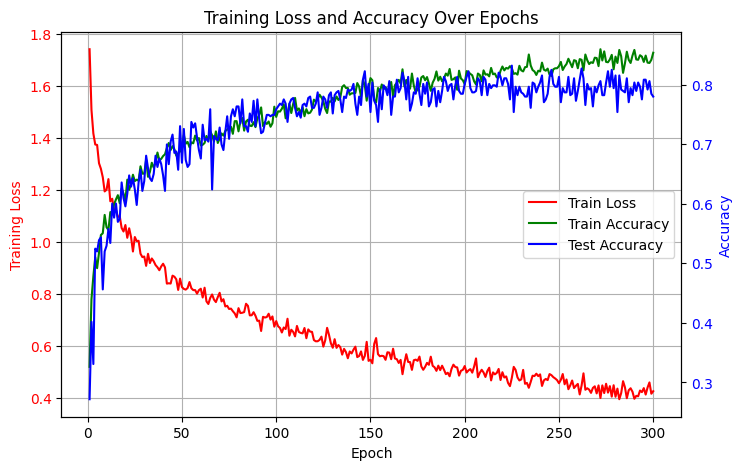

In [100]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot training loss on left y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color='red')
ax1.plot(epochs, train_losses, 'r-', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True)

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='blue')
ax2.plot(epochs, train_accuracies, 'g-', label='Train Accuracy')
ax2.plot(epochs, test_accuracies, 'b-', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor='blue')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.title('Training Loss and Accuracy Over Epochs')
plt.show()